In [88]:
from google.colab import drive
drive.mount( '/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [89]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn import preprocessing
from xgboost import plot_importance
import matplotlib.pyplot as plt


In [90]:
wasterWaterURL = "/gdrive/My Drive/MLcontent/Wastewater_Data.csv"
wasteDF = pd.read_csv(wasterWaterURL, header=0, parse_dates=[0], index_col=0, squeeze=True)
wasteDF = wasteDF.replace('^\s*$', np.nan, regex=True)
wasteDF = wasteDF.fillna(method='ffill')
wasteDF = wasteDF.apply(pd.to_numeric)

In [91]:
def table2lags(table, max_lag, min_lag=1, separator='_'):
    values = []
    for i in range(min_lag, max_lag + 1):
        #append shiffted dataframe into the list (i.e., values)
        values.append(table.shift(i).copy()) 
        #replace the last item or dataframe's columns by column_n; n is the shift step  
        values[-1].columns = [c + separator + str(i) for c in table.columns] 
    #pandas.concat is used to merge all dataframes (as items in values) into a single dataframe
    return pd.concat(values, axis=1)

In [92]:
names = wasteDF.columns
wasteArray = wasteDF.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
wasteArray_scaled = min_max_scaler.fit_transform(wasteArray)
waste_normalized = pd.DataFrame(wasteArray_scaled, columns=names)

In [93]:
lag = 7
#extend input
shiftDF = table2lags(waste_normalized, lag)
shiftDF = shiftDF.fillna(method='bfill')
shiftDF

,Total Solids_1,SS_1,BOD5_1,NH3_1,Org-N_1,P-TOT_1,SO4_1,TKN_1,PRCP_NOOA_1,Total Solids_2,SS_2,BOD5_2,NH3_2,Org-N_2,P-TOT_2,SO4_2,TKN_2,PRCP_NOOA_2,Total Solids_3,SS_3,BOD5_3,NH3_3,Org-N_3,P-TOT_3,SO4_3,TKN_3,PRCP_NOOA_3,Total Solids_4,SS_4,BOD5_4,NH3_4,Org-N_4,P-TOT_4,SO4_4,TKN_4,PRCP_NOOA_4,Total Solids_5,SS_5,BOD5_5,NH3_5,Org-N_5,P-TOT_5,SO4_5,TKN_5,PRCP_NOOA_5,Total Solids_6,SS_6,BOD5_6,NH3_6,Org-N_6,P-TOT_6,SO4_6,TKN_6,PRCP_NOOA_6,Total Solids_7,SS_7,BOD5_7,NH3_7,Org-N_7,P-TOT_7,SO4_7,TKN_7,PRCP_NOOA_7
0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.00000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
1,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.00000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
2,0.178975,0.034832,0.058979,0.456966,0.130081,0.119767,0.441441,0.208316,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.00000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
3,0.240081,0.091197,0.107750,0.415789,0.197832,0.164535,0.441441,0.251656,0.000000,0.178975,0.034832,0.058979,0.456966,0.130081,0.119767,0.441441,0.208316,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.00000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
4,0.204749,0.056998,0.079395,0.454180,0.175248,0.143314,0.441441,0.242636,0.000000,0.240081,0.091197,0.107750,0.415789,0.197832,0.164535,0.441441,0.251656,0.000000,0.178975,0.034832,0.058979,0.456966,0.130081,0.119767,0.441441,0.208316,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.00000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6569,0.216044,0.089297,0.067675,0.563467,0.151762,0.152616,0.558559,0.249049,0.000000,0.178396,0.056998,0.059735,0.566873,0.099368,0.114826,0.558559,0.209232,0.000000,0.168549,0.043699,0.050284,0.511455,0.097561,0.102035,0.684685,0.194715,0.000000,0.155807,0.036732,0.040832,0.508669,0.080397,0.082267,0.684685,0.180691,0.00000,0.170287,0.041165,0.043856,0.477399,0.089431,0.100872,0.684685,0.180832,0.0,0.177816,0.03

In [94]:
def extendList(inputList, lag, separator='_'):
    ret = []
    for s in inputList:
        for i in range(1, lag+1):
            ret.append(s + separator + str(i))
    return ret

In [95]:
#choice input
needFeatures = ['Total Solids', 'SS']
needFeaturesShift = extendList(needFeatures, 7)
shiftDF = shiftDF[needFeaturesShift]


In [96]:
targetname = 'Total Solids'
targetDF = waste_normalized[targetname].to_frame()
type(targetDF)

pandas.core.frame.DataFrame

In [97]:
TVsize = int(len(wasteArray) * 0.6)
VTsize = int(len(wasteArray) * 0.8)

train_data = shiftDF[0:TVsize]
train_target = targetDF[0:TVsize]

val_data = shiftDF[TVsize:VTsize]
val_target = targetDF[TVsize:VTsize]

test_data = shiftDF[VTsize:]
test_target = targetDF[VTsize:]

In [98]:
XGBboost_model = xgb.XGBRegressor()

In [99]:
XGBboost_model.fit(train_data, train_target,
                   eval_set=[(train_data, train_target), (val_data, val_target)],
                   early_stopping_rounds=50,
                   verbose=False)

[22:16:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

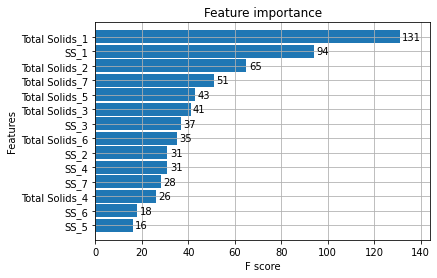

In [100]:
a = plot_importance(XGBboost_model, height=0.9)

In [101]:
presult = XGBboost_model.predict(test_data)

In [121]:
presult

array([0.18422207, 0.19883314, 0.20108086, ..., 0.18554118, 0.16252208,
       0.18218735], dtype=float32)

In [120]:
test_target.values

array([[0.16275702],
       [0.21922966],
       [0.20445989],
       ...,
       [0.17144512],
       [0.16565306],
       [0.17781639]])

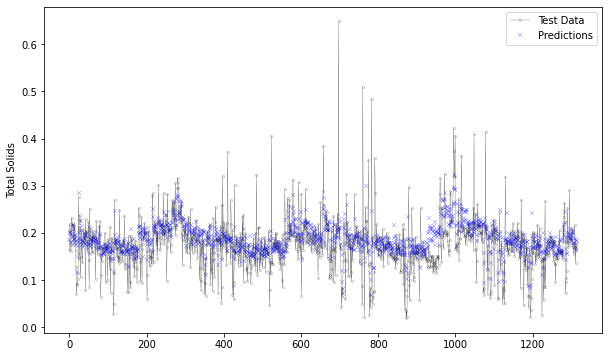

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(test_target.values, color='black', linewidth=.2, marker='o', markersize=2,
                markeredgecolor='black', markeredgewidth=0.2, fillstyle='none')
plt.plot(presult, color='blue', linewidth=4, linestyle=' ', marker='x', markersize=4,
                markeredgecolor='blue', markeredgewidth=.2, fillstyle='none')
plt.legend(('Test Data', 'Predictions'))
plt.ylabel(targetname)

plt.show()

In [124]:
def mae(y_true, y_pred):
  mae = np.mean(np.abs(y_true - y_pred))
  print("mae" + str(mae))


In [125]:
mae(test_target.values, presult)

mae0.04612079979126163
